In [6]:
from main import *
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import EfficientFCParameters


from sklearn.cluster import HDBSCAN, KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

RUNTSFRESH = False
SHORT = False
SAVEPLOTS = True

In [7]:
if SHORT == True:
    machines = ["M01", "M02"]
    process_names = ["OP02","OP07"]
else:
    machines = ["M01", "M02","M03"]
    process_names = ["OP00","OP01","OP02","OP03","OP04","OP05","OP06","OP07","OP08","OP09","OP10","OP11","OP12","OP13","OP14"]
labels = ["good","bad"]
path_to_dataset = Path("./data/").absolute()

In [8]:
X_data = []
y_data = []

for process_name, machine, label in itertools.product(process_names, machines, labels):
    data_path = os.path.join(path_to_dataset, machine, process_name, label)
    data_list, data_label = data_loader_utils.load_tool_research_data(data_path, label=label, add_additional_label = True, verbose = False)
    #concatenating
    X_data.extend(data_list)
    y_data.extend(data_label)

In [ ]:
X, y, features = preprocess_data(X_data, y_data)
y = np.array(y)
features = np.array(features)
plot_class_dist(y, features, SAVEPLOTS)

In [5]:
X = [x.astype(np.float32) for x in X_data] # Ensure all elements in X_data are of type float32

labelnames = [y.split("_")[-1] for y in y_data] # Extract label names and create a binary target vector
target = pd.Series([1 if "bad" in label else 0 for label in labelnames], name="target")


y_id = pd.DataFrame(["_".join(y.split("_")) for y in y_data], columns=["id"]) # Create an id vector and join it with the target
y = y_id.join(target)

# Create a DataFrame for the vibration data (first 4096 rows and first 3 columns for each array in X)
dfx = pd.DataFrame(np.array([x[:4096, :3] for x in X]).reshape(-1, 3), columns=["X-axis", "Y-axis", "Z-axis"])

# Repeat the y DataFrame to match the rows of dfx and add the 'id' column to dfx
dfy = pd.DataFrame(np.repeat(y.values, 4096, axis=0), columns=["id", "target"])
dfx["id"] = dfy["id"]

# Prepare the final y series, set 'id' as the index
y = pd.Series(y["target"].values, index=y["id"])

In [6]:
if RUNTSFRESH == True:
    settings = EfficientFCParameters()
    extracted_features = extract_features(dfx, column_id = "id", default_fc_parameters = settings)
    impute(extracted_features)
    filtered_features = select_features(extracted_features, y)
else:
    filtered_features = pd.read_pickle("data/tsfresh4096.pkl")

In [7]:
scaler = StandardScaler()
scaled_filtered_features = scaler.fit_transform(filtered_features)

pca = PCA(n_components=2)

filtered_pca = pd.DataFrame(pca.fit_transform(scaled_filtered_features))
filtered_pca = filtered_pca.set_index(filtered_features.index)

In [8]:
hdb = HDBSCAN(store_centers = "both")

hdb.fit(filtered_pca)
labels = hdb.labels_

print("filtered_pca sil_score")
print(silhouette_score(filtered_pca, labels))

filtered_pca sil_score
0.7217312662137109


In [9]:
cluster_df = filtered_pca.copy()
cluster_df["cluster"] = labels
cluster_df["target"] = y

In [10]:
cluster_df[(cluster_df["cluster"] == 0) & (cluster_df["target"] == 0)].empty

True

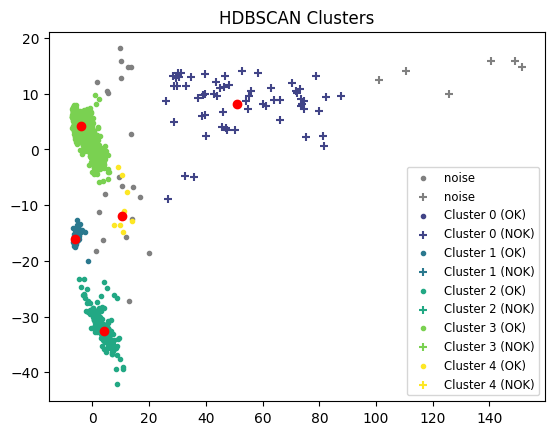

In [11]:
cmap = plt.get_cmap('viridis', len(np.unique(labels)))
clusters = np.sort(cluster_df["cluster"].unique())

markers = [".", "+"]
targets = np.sort(cluster_df["target"].unique())
targetlabel = ["OK", "NOK"]

medoids = hdb.medoids_

for i, cluster in enumerate(clusters):
    for j, target in enumerate(targets):
        plot_df = cluster_df[(cluster_df["cluster"] == cluster) & (cluster_df["target"] == target)]
        marker = markers[j]
        color = "gray" if cluster == -1 else cmap(i)
        label = "noise" if cluster == -1 else f"Cluster {cluster} ({targetlabel[j]})"
        plt.scatter(x = plot_df[0], y = plot_df[1], marker = marker, color = color, label = label)
    
plt.legend(fontsize = "small")
plt.scatter(x = medoids[:, 0], y = medoids[:, 1], color = "red")
plt.title('HDBSCAN Clusters')
plt.show()

In [12]:
medoids = []
medoidpaths = []
for medoid in hdb.medoids_:
    med = cluster_df[(cluster_df[0] == medoid[0]) & (cluster_df[1] == medoid[1])]
    medoidname = med.index[0]
    medoids.append(medoidname)
    s = medoidname.split("_")
    correctmedoid = "_".join(s[:-1])
    medoidpaths.append(f"./data/{s[0]}/{s[3]}/{s[5]}/{correctmedoid}.h5")

M01_Feb_2019_OP12_002_bad (Medoid for cluster 0)


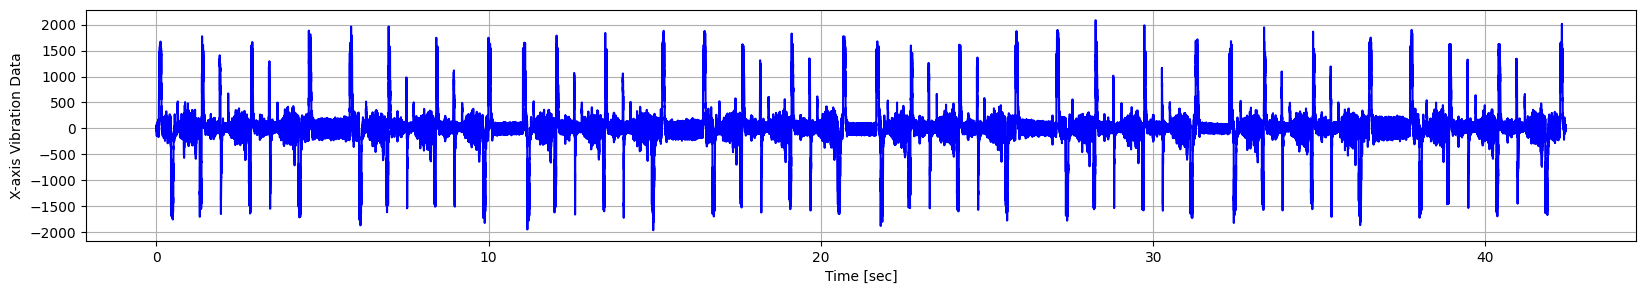

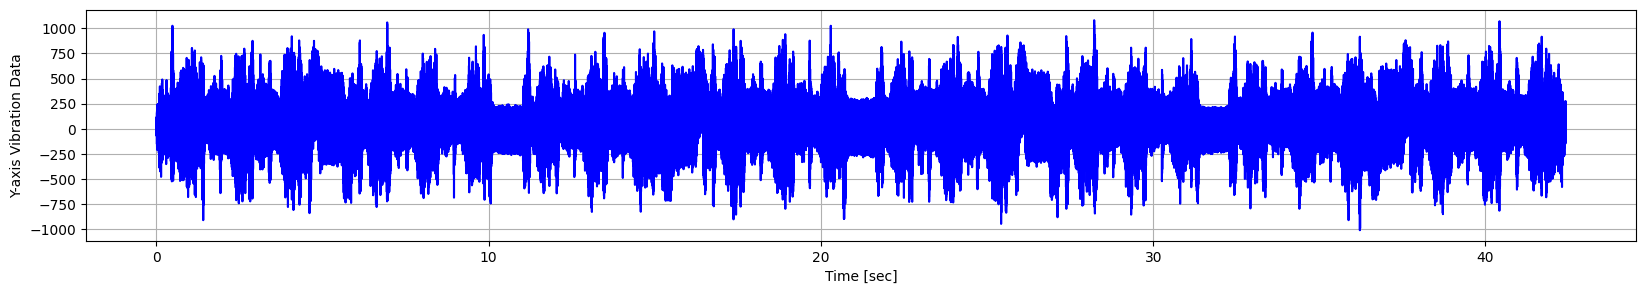

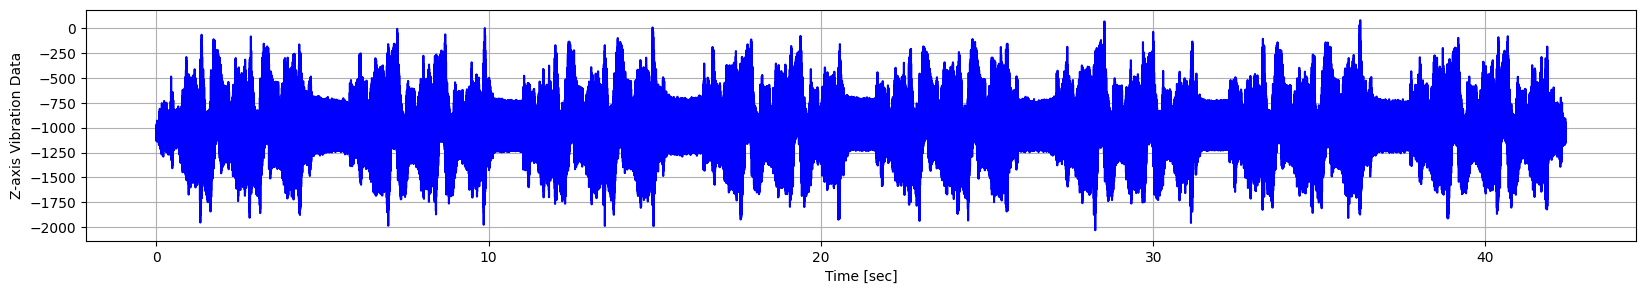

M03_Aug_2019_OP05_015_good (Medoid for cluster 1)


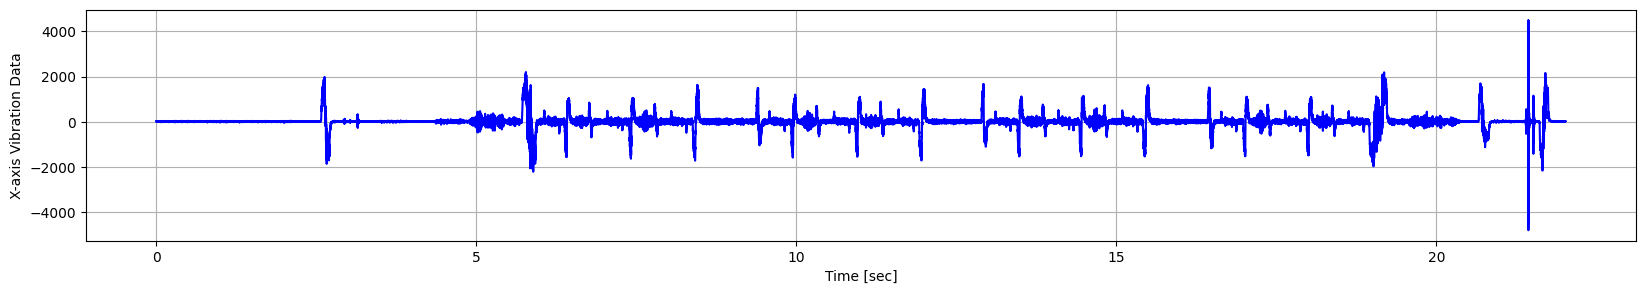

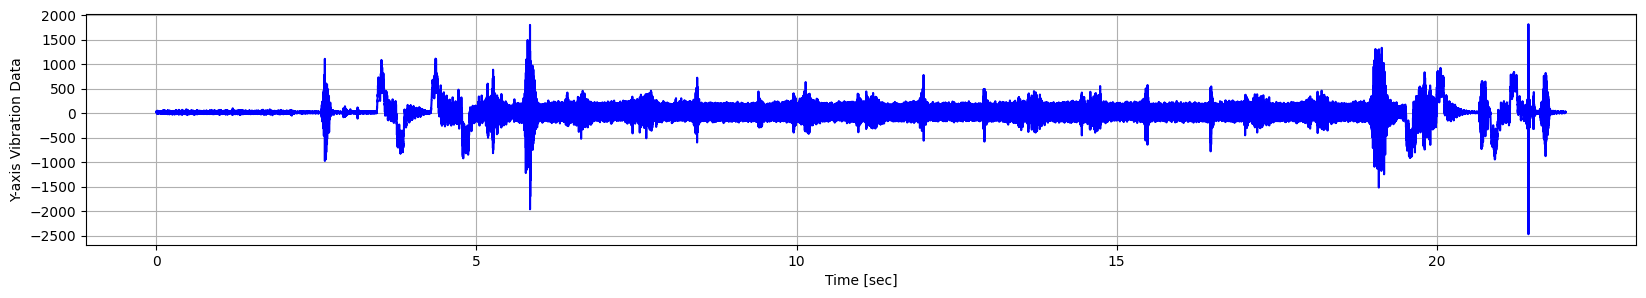

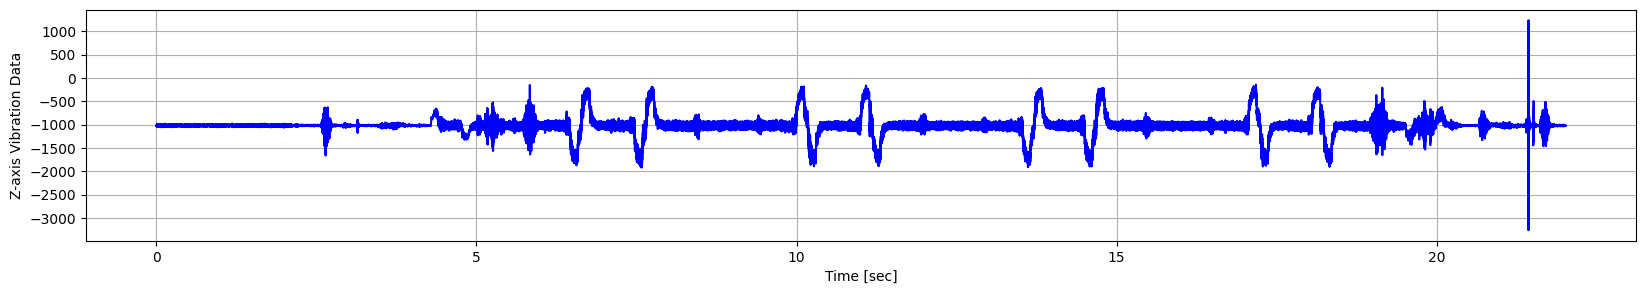

M03_Aug_2019_OP01_002_good (Medoid for cluster 2)


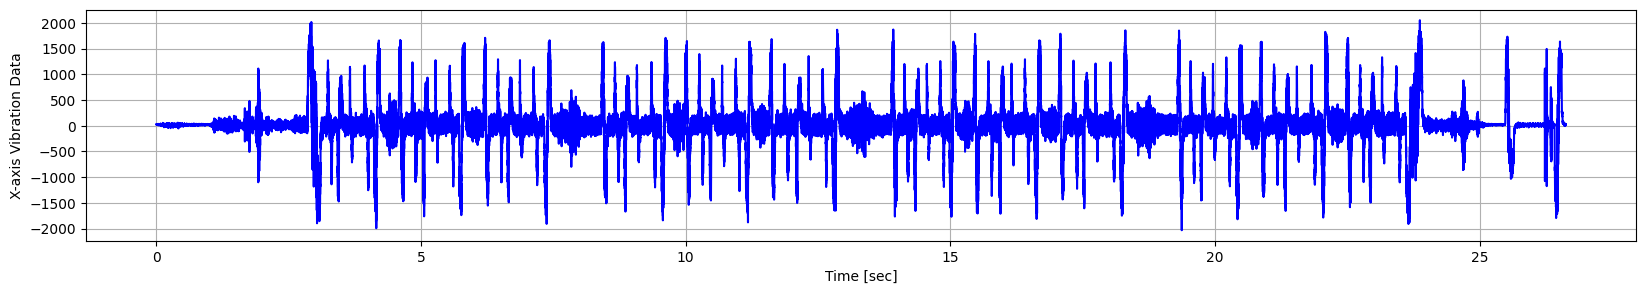

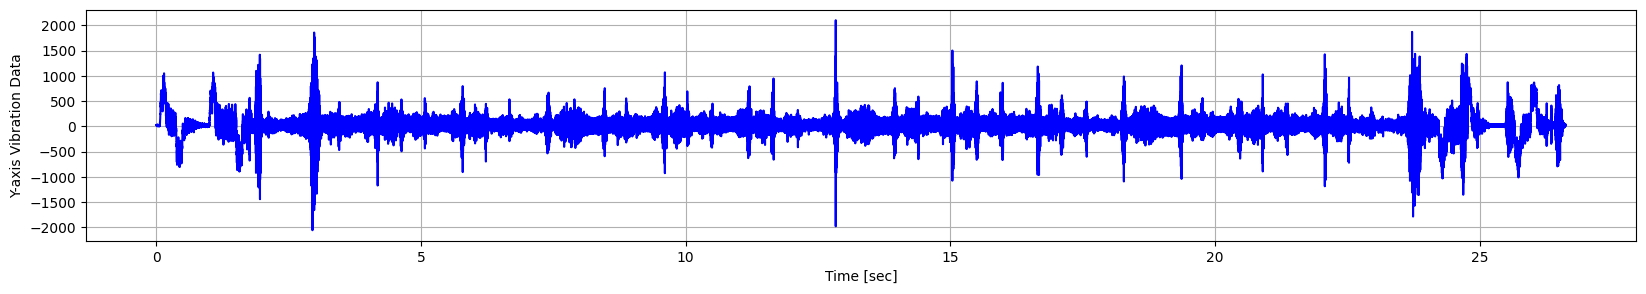

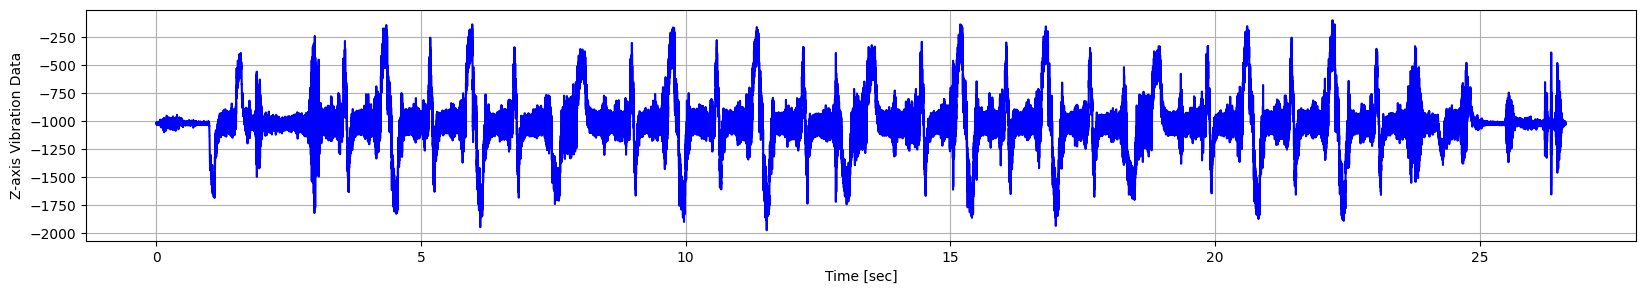

M01_Feb_2021_OP06_001_good (Medoid for cluster 3)


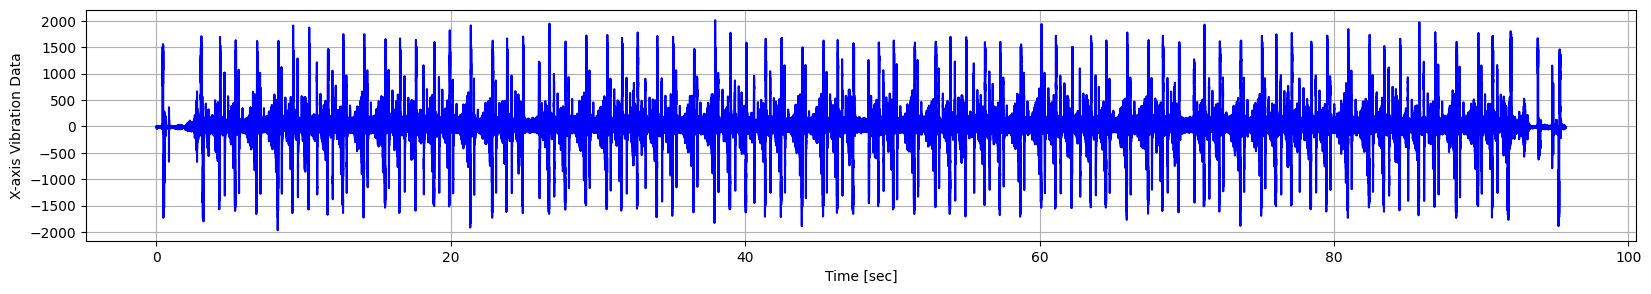

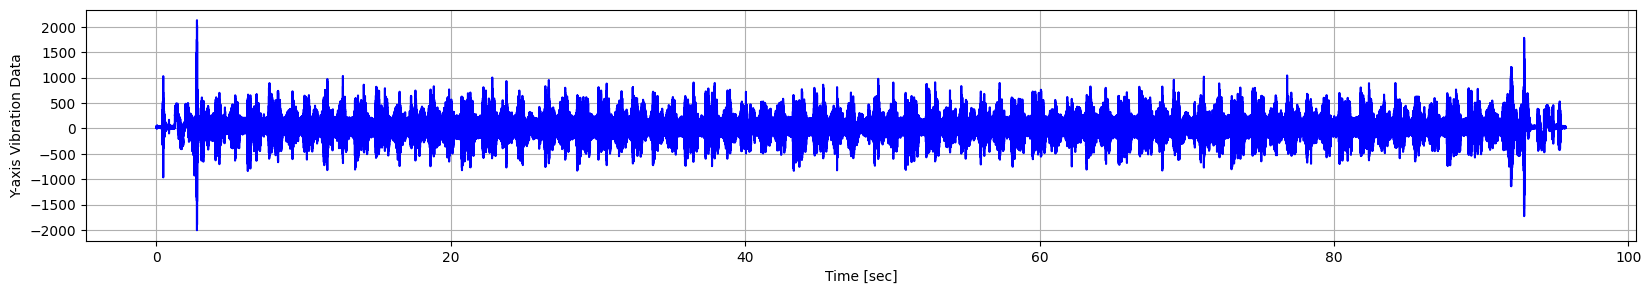

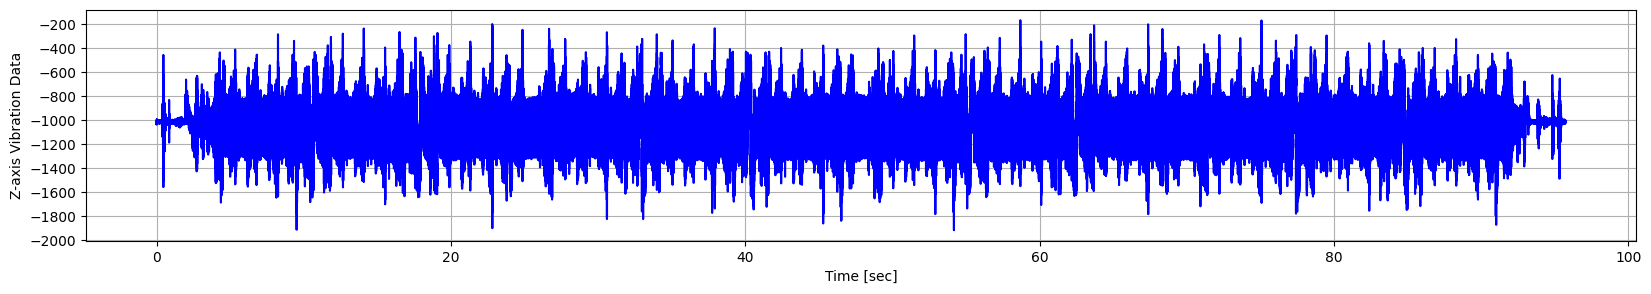

M01_Aug_2021_OP07_001_bad (Medoid for cluster 4)


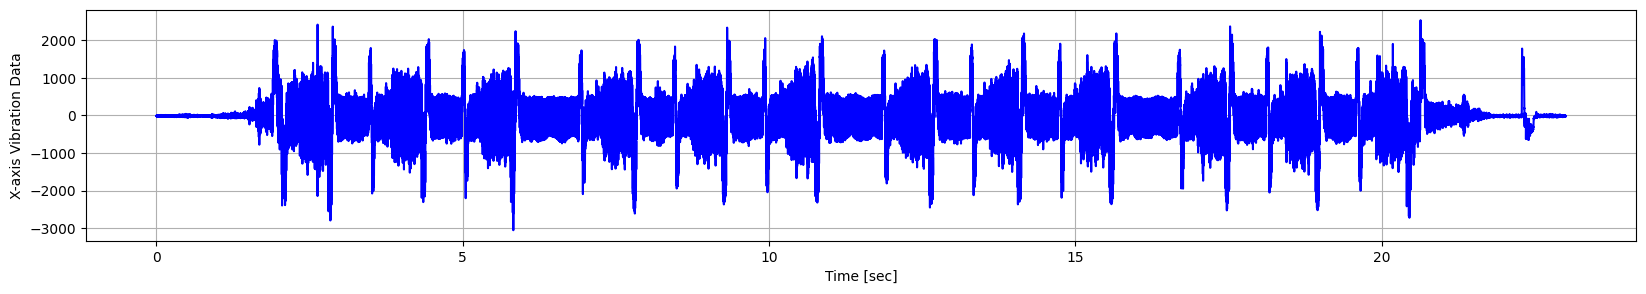

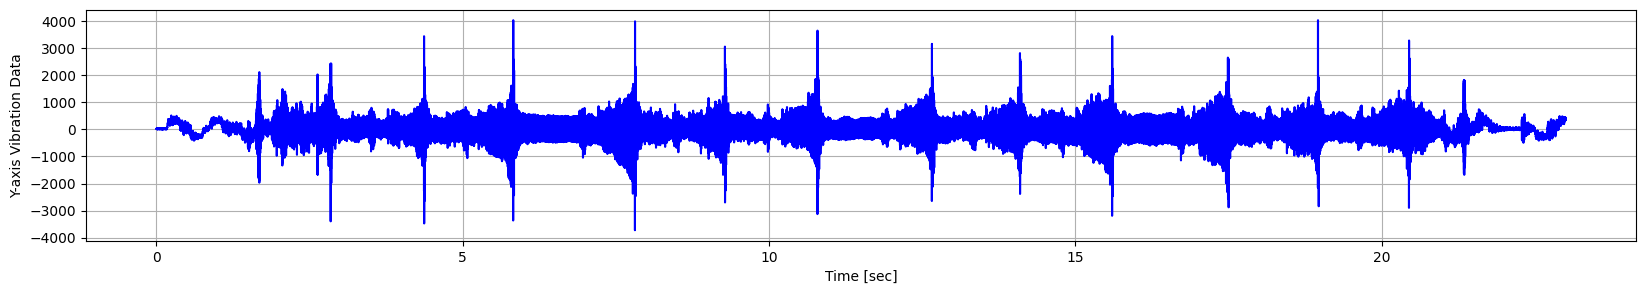

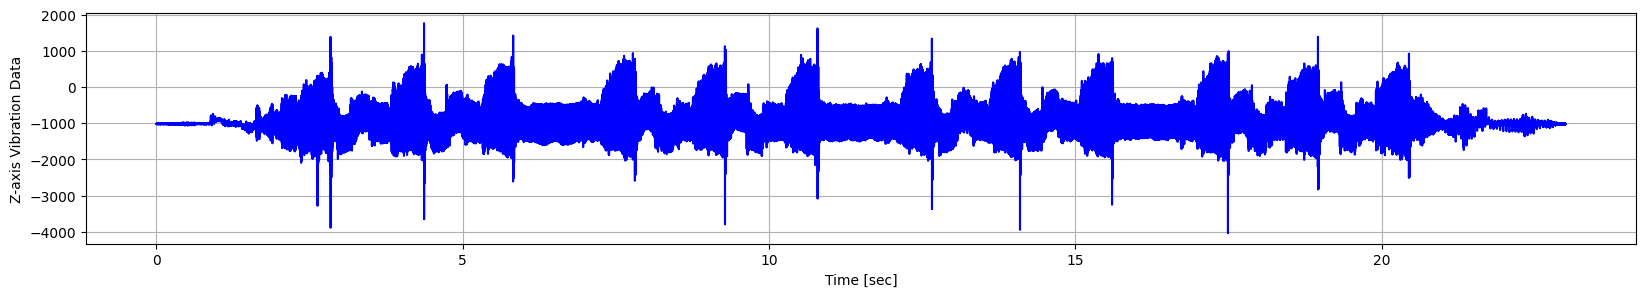

In [13]:
for i, (name, path) in enumerate(zip(medoids, medoidpaths)):
    print(f"{name} (Medoid for cluster {i})")
    file = Path(path).absolute()
    data_loader_utils.datafile_read(file)